In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [5]:
#load dataset
data = datasets.MNIST(root="dataset/", transform=transforms, download=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5465351.61it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 157305.40it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1320994.07it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2377749.47it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [6]:
##getting images of 9
print(sum(data.targets == 9))
data_9 = data.data[data.targets == 9]
data_9.shape

tensor(5949)


torch.Size([5949, 28, 28])

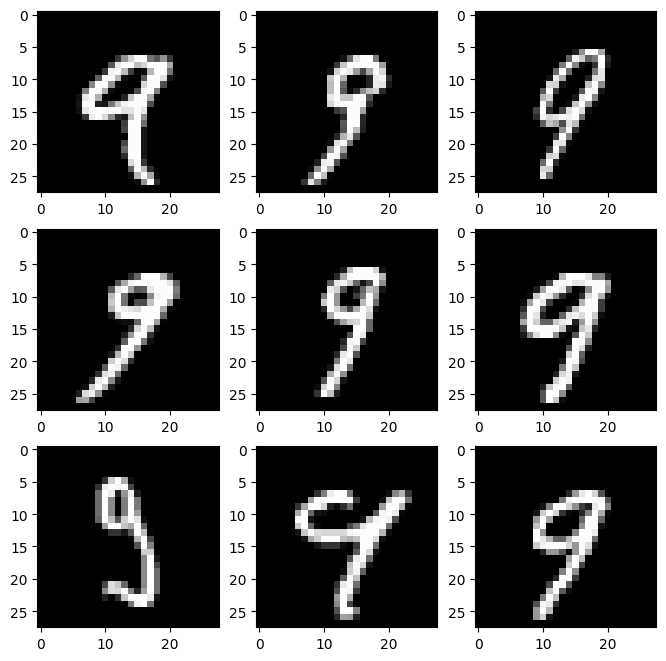

In [7]:
import matplotlib.pyplot as plt

sample = data_9[:9,:,:]
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i, img in enumerate(sample):
    ax.ravel()[i].imshow(img, cmap='gray')
    #ax.ravel()[i].set_axis_off()
plt.show()

## Model Arch

In [134]:
class Discriminator(nn.Module):
  def __init__(self, img_dim):
    super().__init__()
    self.discriminator = nn.Sequential(
        nn.Linear(img_dim, 128), #input
        nn.LeakyReLU(0.1),
        nn.Linear(128, 1), #output
        nn.Sigmoid(), #softmax
    )
  def forward(self, x):
    return self.discriminator(x
    )

class Generator(nn.Module):
  def __init__(self, z_dim, img_dim):
    super().__init__()
    self.generator = nn.Sequential(
            nn.Linear(z_dim, 512), #input
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, img_dim), # Output layer
            nn.Tanh()  # Output activation for image generation
        )

  def forward(self, x):
    return self.generator(x)

In [135]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [146]:
import torchvision.transforms as transforms

#initializing variables
lr_disc = 1e-4
lr_gan = 1e-4

z_dim = 32
image_dim = 28 * 28 * 1
batch_size = 32
num_epochs = 16

#initialize model
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)

#fixed noise to test generator
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

#transformations
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [147]:
loader = DataLoader(dataset = data_9, batch_size = batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr_disc)
opt_gen = optim.Adam(gen.parameters(), lr=lr_gan)
loss = nn.BCELoss()

# #TensorBoard
# writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
# writer_real = SummaryWriter(f"runs/GAN_MNIST/real")

In [148]:
step = 0
generated_images = []
real_images = []

g_loss_disc = []
g_loss_gen = []

# Training Loop
for epoch in range(num_epochs):
  avg_loss_disc = []
  avg_loss_gen = []

  for batch_idx, real in enumerate(loader):
    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]

    ##Generate noise
    noise = torch.randn(batch_size, z_dim).to(device)

    ## STEP 1: Generate batch fake images
    gen.train()
    fake = gen(noise)

    ### STEP 2: TRAIN Discrimator to classify fake or real
      ## 2.1 Real image loss
    disc.train()
    disc_real = disc(real.type(torch.float32)).view(-1)
    loss_disc_real = loss(disc_real, torch.ones_like(disc_real))

      ## 2.2 Fake image loss
    disc_fake = disc(fake).view(-1)
    loss_disc_fake = loss(disc_fake, torch.zeros_like(disc_fake))

      ## 2.3 average loss
    loss_disc = (loss_disc_real + loss_disc_fake) / 2

      ## Discriminator backward pass
    disc.zero_grad() #set gradient
    loss_disc.backward(retain_graph=True) #retain_graph? #calculate gradient
    opt_disc.step() #update weights

    ### ------------------------------------
    ### STEP 3: Train Generator based on discrimator eval
    disc.eval()
    output = disc(fake).view(-1) #why we do this thing again
    loss_gen = loss(output, torch.ones_like(output)) #? disc tells fake(0) but we need it be real(1)
    ## 3.1 Generator backward pass
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    ##
    avg_loss_disc.append(loss_disc.item())
    avg_loss_gen.append(loss_gen.item())

    ##results
    if batch_idx == batch_size-1:
      g_loss_disc.append(np.average(avg_loss_disc))
      g_loss_gen.append(np.average(avg_loss_gen))

      print(f"Epoch [{epoch}/ {num_epochs}]",
            f"LossD : {np.average(avg_loss_disc):.4f}, LossG : {np.average(avg_loss_gen):.4f}", sep='\n')
      ##Store results
      with torch.no_grad():
        gen.eval()
        fake = gen(fixed_noise).reshape(-1, 28, 28).detach().cpu().numpy()
        data = real.reshape(-1, 28, 28).detach().cpu().numpy()

        generated_images.append(fake)
        real_images.append(data)
        # img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
        # img_grid_real = torchvision.utils.make_grid(data, normalize=True)

        # writer_fake.add_image("Mnist Fake Images", img_grid_fake, global_step=step)
        # writer_real.add_image("Mnist Real Images", img_grid_real, global_step=step)

        step += 1


Epoch [0/ 16]
LossD : 0.4518, LossG : 0.6118
Epoch [1/ 16]
LossD : 0.4562, LossG : 0.5193
Epoch [2/ 16]
LossD : 0.3847, LossG : 0.6304
Epoch [3/ 16]
LossD : 0.3333, LossG : 0.7316
Epoch [4/ 16]
LossD : 0.3102, LossG : 0.7892
Epoch [5/ 16]
LossD : 0.3116, LossG : 0.8025
Epoch [6/ 16]
LossD : 0.2763, LossG : 0.9053
Epoch [7/ 16]
LossD : 0.2461, LossG : 1.0091
Epoch [8/ 16]
LossD : 0.2224, LossG : 1.0943
Epoch [9/ 16]
LossD : 0.1963, LossG : 1.1861
Epoch [10/ 16]
LossD : 0.1846, LossG : 1.2503
Epoch [11/ 16]
LossD : 0.1670, LossG : 1.3362
Epoch [12/ 16]
LossD : 0.1469, LossG : 1.4779
Epoch [13/ 16]
LossD : 0.1143, LossG : 1.6506
Epoch [14/ 16]
LossD : 0.1300, LossG : 1.5928
Epoch [15/ 16]
LossD : 0.1067, LossG : 1.7311


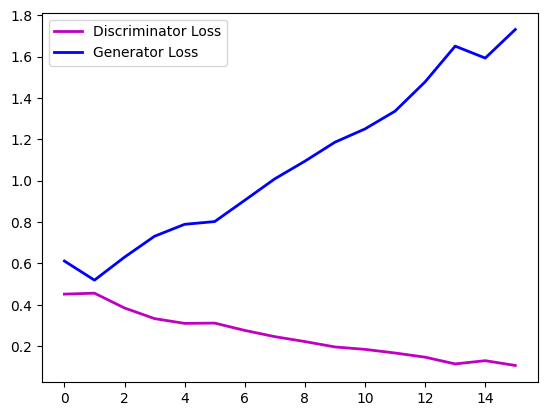

In [150]:
plt.plot(g_loss_disc, label='Discriminator Loss', c='m', lw=2)
plt.plot(g_loss_gen, label='Generator Loss', c='b', lw=2)
plt.legend()
plt.show()

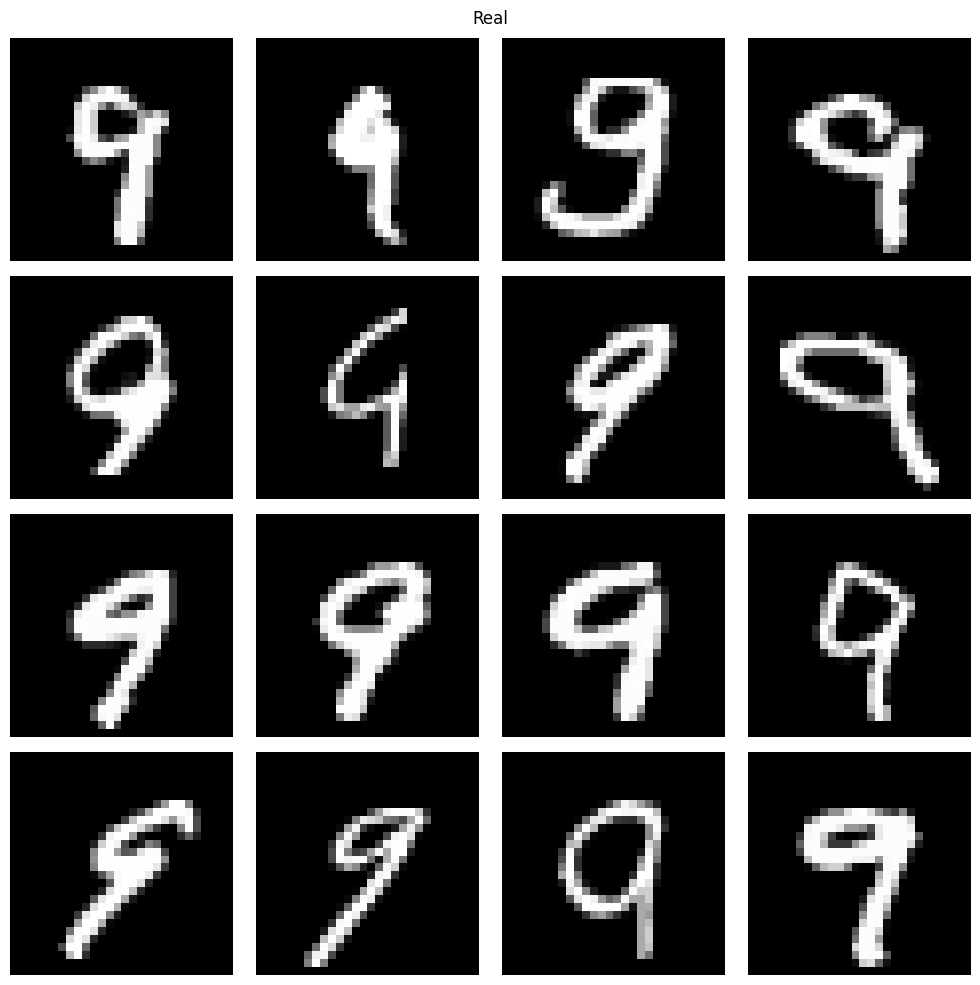

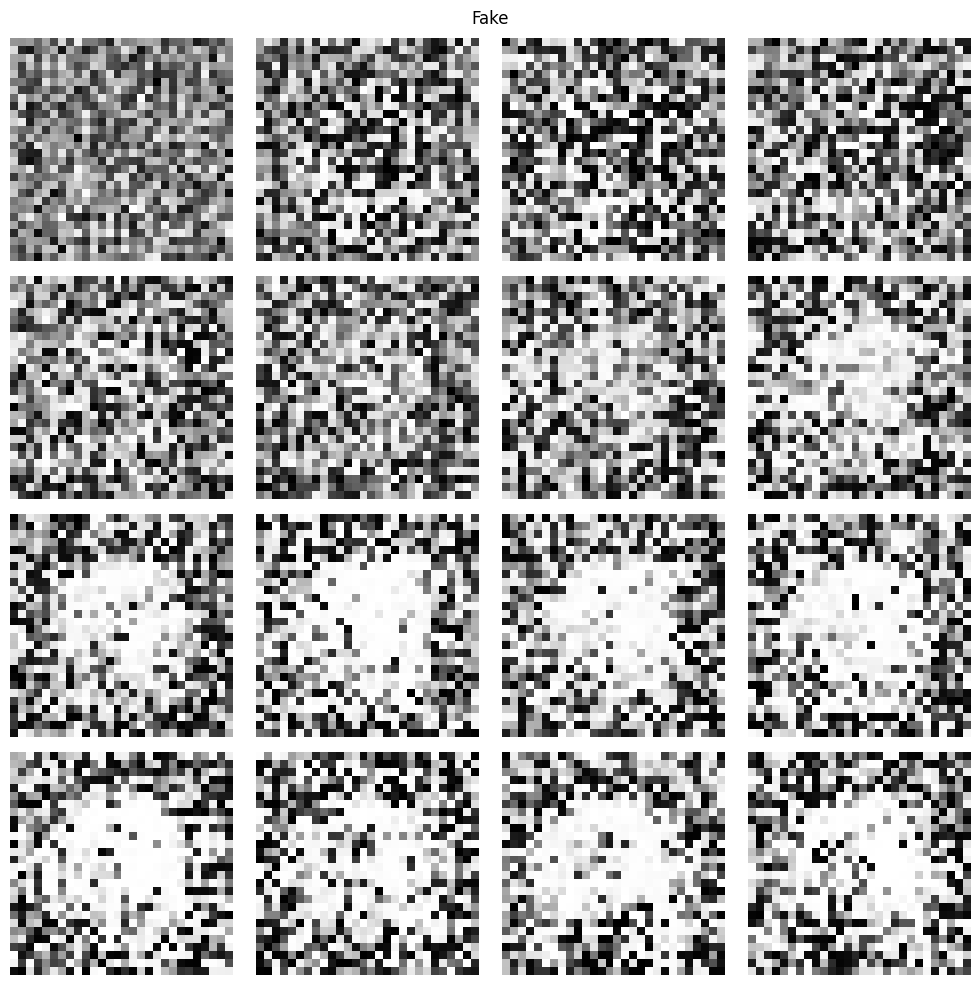

In [151]:
#display gan generated images

def display_images(images, title, nrows=None, ncols=None):
  num_images = len(images)
  if nrows is None and ncols is None:
      # Automatic layout based on square root
      nrows = int(np.sqrt(num_images))
      ncols = int(np.ceil(num_images / nrows))
  elif nrows is None:
      # Calculate ncols based on provided nrows
      ncols = int(np.ceil(num_images / nrows))
  elif ncols is None:
      # Calculate nrows based on provided ncols
      nrows = int(np.ceil(num_images / ncols))

  fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))  # Adjust figsize as needed

  # Iterate over images and axes, handling variable sizes
  for i in range(nrows):
      for j in range(ncols):
          if i * ncols + j < num_images:
              # Ensure valid index to avoid IndexError
              ax = axes[i, j]
              ax.imshow(images[i * ncols + j][0], cmap='gray')
              ax.axis('off')
          else:
              # Hide unused axes (optional)
              axes[i, j].axis('off')
              axes[i, j].set_visible(False)

  fig.suptitle(title)
  plt.tight_layout()
  plt.show()

display_images(real_images, "Real")
display_images(generated_images, "Fake")